In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Mount your google drive if you run in google collab (need to re-mount if drive is updated)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load data for half input images
import os

path = 'drive/MyDrive/src'
img_dir = os.path.join(path, "img")
datafile = os.path.join(path,'data.txt')

f = open(datafile)
content = f.read()
f.close()

data = []

for line in content.split('\n'):
    if line != '':
        row = line.split(';')
        data.append(list(map(float, row)))


data = np.asarray(data)

In [5]:
data.shape

(10000, 392)

In [6]:
def image_combiner(cut, generated):
  full_image = np.concatenate((cut,generated))
  return full_image

In [7]:
import math

def psnr(img_data1, img_data2):
    mse = np.mean( (img_data1 - img_data2) ** 2 )
    if mse == 0:
      return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def max_error (img_data1, img_data2):
    return np.max(abs(img_data1-img_data2))

In [8]:
def scrap_outputs(bits) :
  outfile = os.path.join(path, ('output_bits' + str(bits) + '.txt'))

  f = open(outfile)
  content = f.readlines()[1:]
  f.close()

  data_sw = []
  data_hw = []

  for s in content:
    t = s.split(';')
    data_sw.append(float(t[0]))
    data_hw.append(float((t[1].split('\n'))[0]))

  data_sw = np.asarray(data_sw)
  data_hw = np.asarray(data_hw)

  return data_sw, data_hw

In [9]:
def create_img(bits, idx, data_sw, data_hw):
  offset = 14*28

  # combined image for software output
  output_sw = image_combiner(data[idx,:].reshape(14,28), data_sw[idx*offset:idx*offset+offset].reshape(14,28))

  # combined image for hardware output
  output_hw = image_combiner(data[idx,:].reshape(14,28), data_hw[idx*offset:idx*offset+offset].reshape(14,28))

  plt.figure()
  plt.imshow(output_sw.reshape((28,28)).astype(np.float32), cmap = 'gray')
  plt.axis('off')
  figpath_SW = os.path.join(img_dir, (f"SW_bits{bits}_idx{idx}.png"))
  plt.savefig(figpath_SW)

  plt.figure()
  plt.imshow(output_hw.reshape((28,28)).astype(np.float32), cmap = 'gray')
  plt.axis('off')
  figpath_HW = os.path.join(img_dir, (f"HW_bits{bits}_idx{idx}.png"))
  plt.savefig(figpath_HW)

  plt.close()

  return output_sw, output_hw

In [10]:
def calc_error(output_sw, output_hw):
  img_data_sw=(output_sw*127.5 + 127.5).astype(int)
  img_data_hw=(output_hw*127.5 + 127.5).astype(int)
  max_err = max_error(img_data_sw, img_data_hw)
  psnr_val = psnr(img_data_sw, img_data_hw)

  return max_err, psnr_val

<ipython-input-9-ba6fc356a88b>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
<ipython-input-9-ba6fc356a88b>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Max Error  {(3, 10): 255, (3, 11): 255, (3, 12): 255, (4, 10): 255, (4, 11): 249, (4, 12): 255, (5, 10): 200, (5, 11): 155, (5, 12): 229, (6, 10): 91, (6, 11): 98, (6, 12): 93, (7, 10): 53, (7, 11): 39, (7, 12): 84, (8, 10): 16, (8, 11): 17, (8, 12): 13, (9, 10): 8, (9, 11): 7, (9, 12): 6, (10, 10): 5, (10, 11): 5, (10, 12): 4}
PSNR   {(3, 10): 13.598006427897612, (3, 11): 10.951273518816551, (3, 12): 14.412458999930394, (4, 10): 14.051663945384881, (4, 11): 14.634988266184102, (4, 12): 13.525831164368576, (5, 10): 20.32370043626041, (5, 11): 22.354010215775265, (5, 12): 19.407263480245117, (6, 10): 28.159872103979914, (6, 11): 27.496646597732962, (6, 12): 29.23557136050292, (7, 10): 32.77870229255662, (7, 11): 37.09878984137624, (7, 12): 32.654500509492976, (8, 10): 42.6822168370888, (8, 11): 42.56993337396983, (8, 12): 47.065287020211215, (9, 10): 50.76968548527325, (9, 11): 49.98975523417636, (9, 12): 51.955130625734746, (10, 10): 54.08543347142643, (10, 11): 52.556099880280584, (10

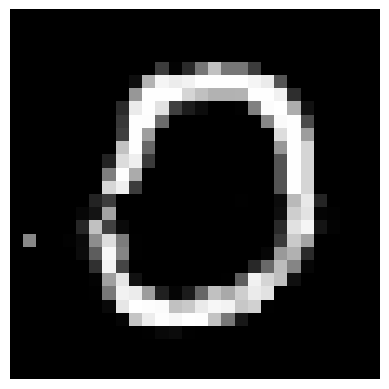

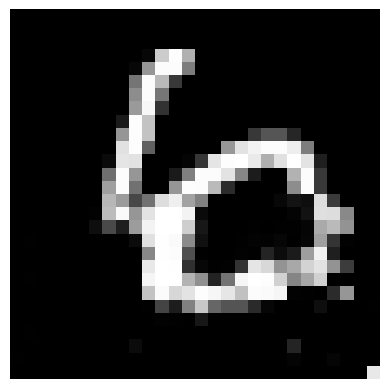

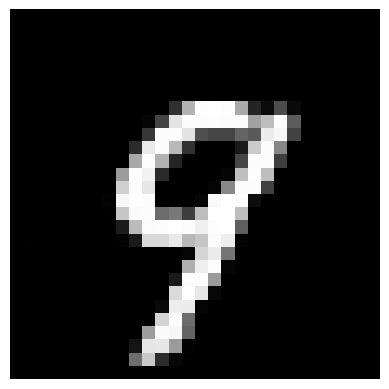

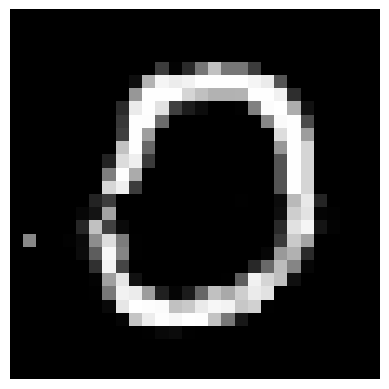

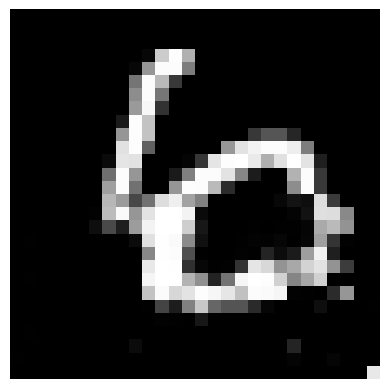

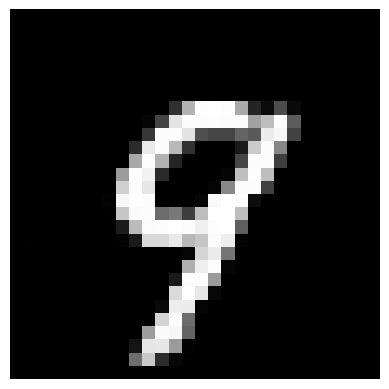

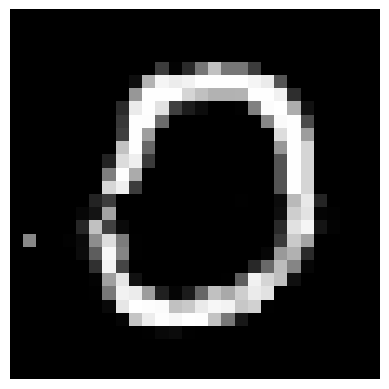

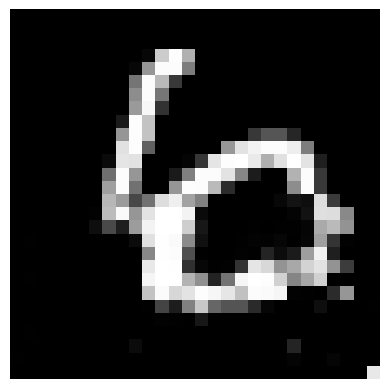

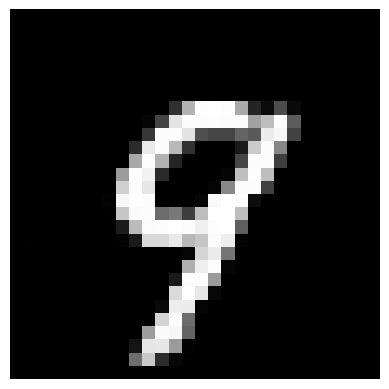

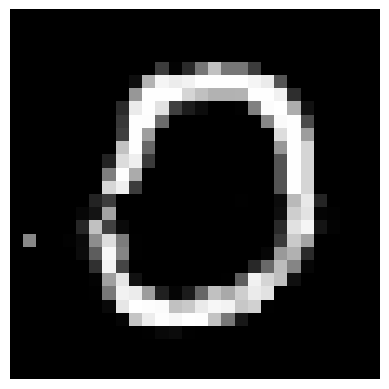

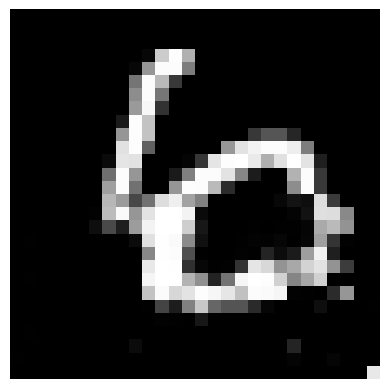

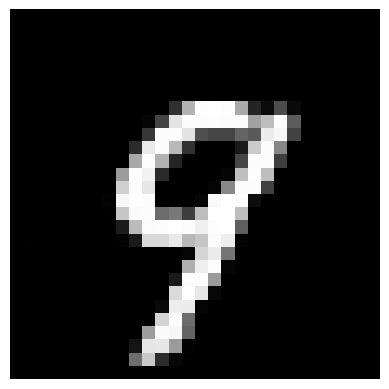

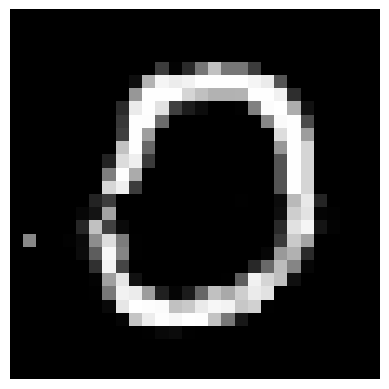

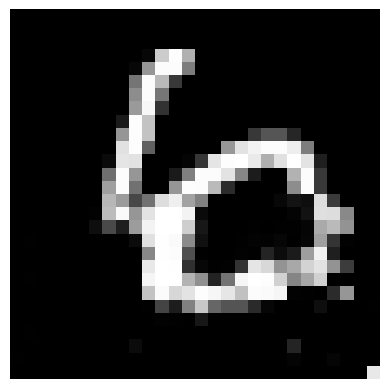

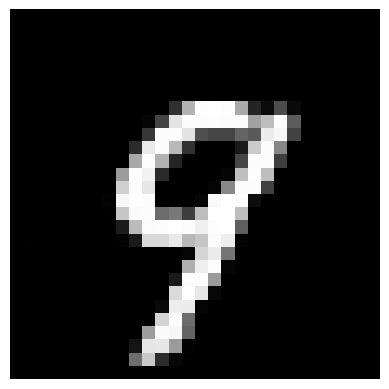

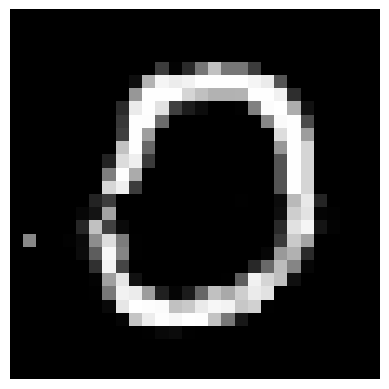

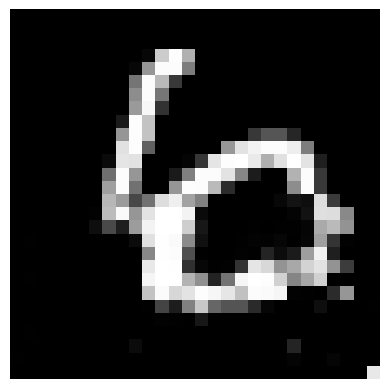

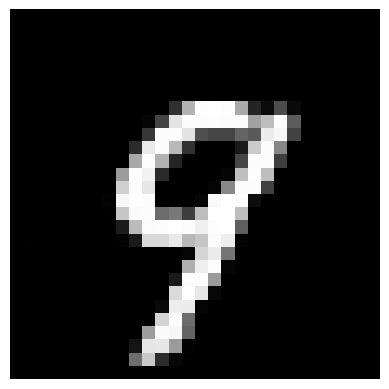

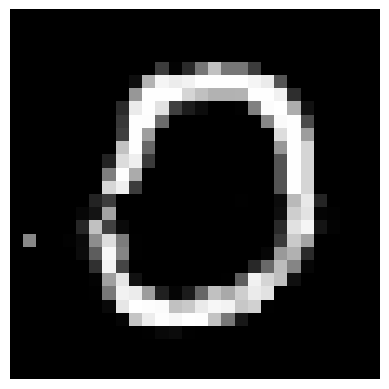

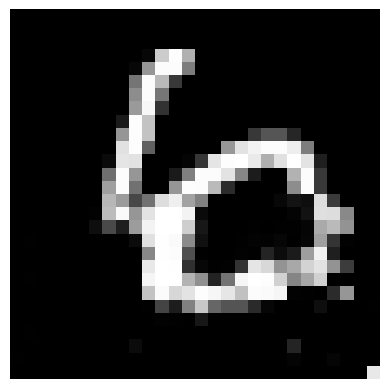

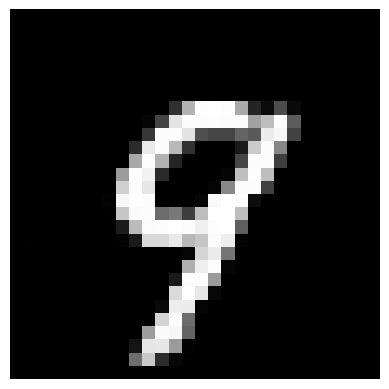

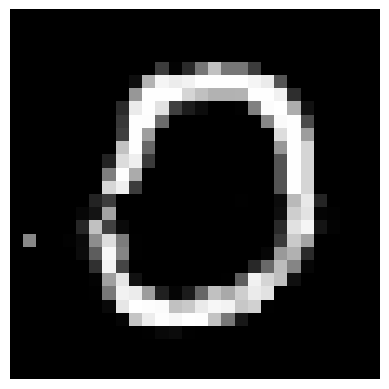

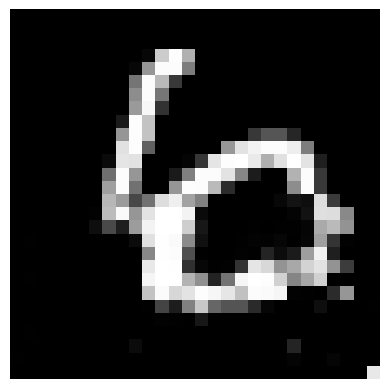

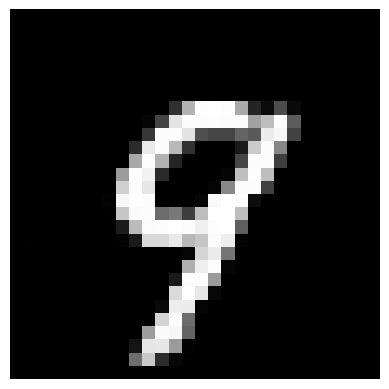

In [11]:
max_err_vals = {}
psnr_vals = {}

for b in [3,4,5,6,7,8,9,10]:
  data_sw, data_hw = scrap_outputs(b)
  for idx in [10,11,12]:
    output_sw, output_hw = create_img(b, idx, data_sw, data_hw)
    max_err, psnr_val = calc_error(output_sw, output_hw)
    max_err_vals[(b,idx)]= max_err
    psnr_vals[(b,idx)] = psnr_val

print("Max Error ", max_err_vals)
print("PSNR  ", psnr_vals)

In [13]:
import csv

resfile = os.path.join(img_dir, "metrics.csv")

with open(resfile, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['BITS', 'index', 'Maximum Pixel Error', 'Peak Signal-to_Noise Ratio'])

    for key in max_err_vals:
        b, idx = key
        max_err = max_err_vals[key]
        psnr_val = psnr_vals[key]
        writer.writerow([b, idx, max_err, psnr_val])